In [2]:
try:
    from linclab_utils import plot_utils
except ImportError as err:
    !pip install -q git+https://github.com/linclab/linclab_utils.git
    from linclab_utils import plot_utils

In [22]:
import wandb
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D
plot_utils.linclab_plt_defaults(font="Arial", fontdir="fonts")
from matplotlib.pyplot import cm
import re
import math
import matplotlib.gridspec as gridspec
import json
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

api = wandb.Api(timeout=19)

In [4]:
# Fetch runs for a specific project
def fetch_runs(api, entity, project_name, filters, order=None):
    if order:
        runs = api.runs(f"{entity}/{project_name}", filters=filters, order=order)
    else:
        runs = api.runs(f"{entity}/{project_name}", filters=filters)
    #print(f"Runs for project '{project_name}':")
    return runs

In [6]:
def same_config(config1, config2, keys=['normtype']):
    for key in keys:
        if config1[key] != config2[key]:
            return False
    return True

/tmp/ipykernel_251296/3515409983.py:24: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='black')


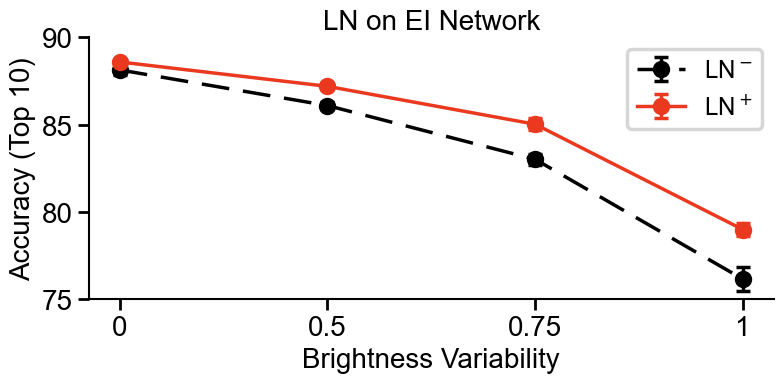

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
brightness_factor = [0, 0.5, 0.75, 1]
best_n_runs = 10
noln_acc = []
ln_acc = []
noln_err = []
ln_err = []

for bf in brightness_factor:

    layernorm_ei_network = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bf, "config.layer_norm": 1, "config.excitation_training": 0, "config.normtype_detach": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
    no_layernorm_ei_network = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bf, "config.layer_norm": 0, "config.excitation_training": 0, "config.normtype_detach": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")[:best_n_runs]
    
                                                                
    noln_acc.append(np.median([run_noln.summary['test_acc'] for run_noln in no_layernorm_ei_network ]))
    ln_acc.append(np.median([run_ln.summary['test_acc'] for run_ln in layernorm_ei_network]))
    noln_err.append(np.std([run_noln.summary['test_acc'] for run_noln in no_layernorm_ei_network ]))
    ln_err.append(np.std([run_ln.summary['test_acc'] for run_ln in layernorm_ei_network]))

ax.errorbar(range(len(noln_acc)), noln_acc, yerr=noln_err, fmt='-o', linestyle='--', label='LN$^-$', capsize=5, color='black')
ax.errorbar(range(len(ln_acc)), ln_acc, yerr=ln_err, fmt='-o',  label='LN$^+$', capsize=5, color='#eb3920')
plt.xticks(range(len(noln_acc)), [str(ele) for ele in brightness_factor], fontsize=25)
plt.legend()

ax.set_xlabel('Brightness Variability', fontsize=20)
ax.set_ylabel(f'Accuracy (Top {best_n_runs})', fontsize=20)
ax.set_title(f'LN on EI Network', fontsize=20)

# Set larger font sizes for the tick numbers
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Get the current x and y ticks
x_ticks = ax.get_xticks()
y_ticks = ax.get_yticks()

ax.set_ylim(75,90)
plt.savefig("figure1a.svg", format="svg")

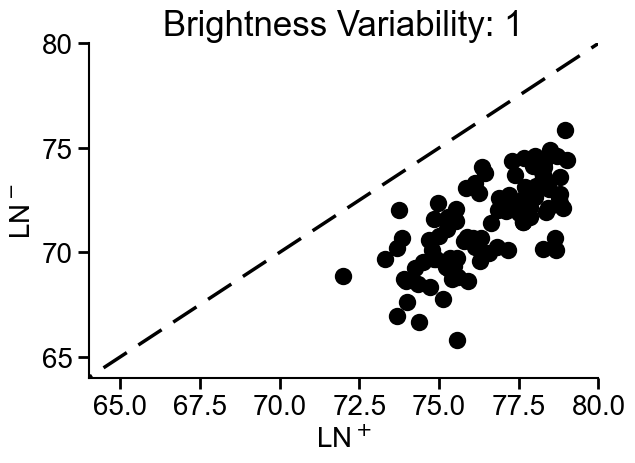

In [8]:
fig, ax = plt.subplots()

bright_factor = 1
runs_dict = dict()
runs_dict["runs_vanilla_dann"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 0, "config.normtype_detach": None,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

runs_dict["runs_vanilla_dann_layernorm"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_NAISYS_GradientAdjustedHomeostasis', filters={"config.dataset": "fashionmnist", 
                                                            "config.brightness_factor": bright_factor, "config.homeostasis": 0, "config.normtype": 1, "config.normtype_detach": 0,
                                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

cmap = plt.get_cmap('viridis')


top_n = len(runs_dict["runs_vanilla_dann"])

for top in range(top_n):

    vanilla_dann_acc = runs_dict["runs_vanilla_dann"][top].summary['test_acc']

    for rn in runs_dict["runs_vanilla_dann_layernorm"]:
        if same_config(rn.config, runs_dict["runs_vanilla_dann"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum', 'homeostasis']):
            plt.scatter(rn.summary['test_acc'], vanilla_dann_acc, color="black")




ax.set_xlabel(f"LN$^+$", fontsize=20)
ax.set_ylabel("LN$^-$", fontsize=20)
# Set larger font sizes for the tick numbers
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_title(f"Brightness Variability: {bright_factor}", fontsize=25)
list_line = range(100)
ax.set_xlim(64, 80)
ax.set_ylim(64, 80)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')
plt.savefig("figure2a.svg", format="svg")

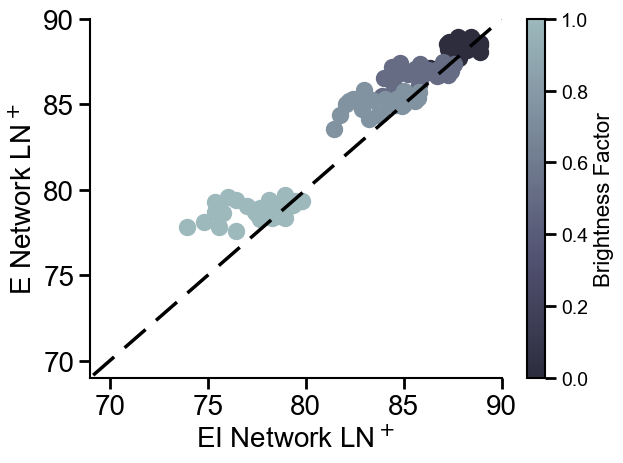

In [62]:
fig, ax = plt.subplots()

# Example brightness factors used
brightness_values = [0, 0.5, 0.75, 1]

# Normalize brightness for colormap mapping
norm = mcolors.Normalize(vmin=min(brightness_values), vmax=max(brightness_values))

def truncate_colormap(cmap, minval=0.2, maxval=1.0, n=256):
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f'trunc({cmap.name},{minval:.2f},{maxval:.2f})',
        cmap(np.linspace(minval, maxval, n))
    )
    return new_cmap

# Create a grayscale colormap from 20% (dark gray) to 100% (black)
cmap = truncate_colormap(plt.get_cmap('bone'), 0.2, 0.7)

scatter_handles = []  # For legend proxy if needed

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.plot(list_line, list_line, label='y = x', color='black', linestyle='--')
ax.set_xlabel(f"EI Network LN$^+$", fontsize=20)
ax.set_ylabel("E Network LN$^+$", fontsize=20)

for bfi in brightness_values:
    color = cmap(norm(bfi))

    runs_dict = dict()
    runs_dict["runs_e_network_ln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                            "config.brightness_factor": bfi, "config.layer_norm": 1, "config.excitation_training": 1, "config.normtype_detach": 0,
                                            "config.use_testset": True}, order="-summary_metrics.test_acc")
    runs_dict["runs_ei_network_ln"] = fetch_runs(api, entity='project_danns', project_name='Luminosity_LNHomeostasis', filters={"config.dataset": "fashionmnist", 
                                            "config.brightness_factor": bfi, "config.layer_norm": 1, "config.excitation_training": 0, "config.normtype_detach": 0,
                                            "config.use_testset": True}, order="-summary_metrics.test_acc")

    top_n = len(runs_dict["runs_e_network_ln"])

    for top in range(top_n):
        vanilla_dann_acc = runs_dict["runs_e_network_ln"][top].summary['test_acc']
        for rn in runs_dict["runs_ei_network_ln"]:
            if same_config(rn.config, runs_dict["runs_e_network_ln"][top].config, keys=['lr', 'wd','inhib_lrs', 'momentum', 'inhib_momentum']):
                sc = ax.scatter(rn.summary['test_acc'], vanilla_dann_acc, color=color)
                break  # Only label once per brightness group
ax.set_xlim(69, 90)
ax.set_ylim(69, 90)

sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Brightness Factor', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.savefig("figure1c.svg", format="svg")